In [1]:
from sklearn.cross_validation import KFold
import pandas as pd
import numpy as np

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = pd.read_csv('../data/processed/cat_week_time_264.csv')
data = data.fillna(0)
print data.shape
data.head()

(2101, 267)


,census_tract,label,label_bucket,num_checkins,num_park,num_fri,num_4pm_8pm,num_thu,num_12pm_4pm,num_bus_station,...,num_swiss_restaurant,num_peruvian_restaurant,num_gluten_free_restaurant,num_funeral_home,num_law_school,num_pet_service,num_recycling_facility,num_internet_cafe,num_motorcycle_shop,num_planetarium
0,36005000200,72034.0,54596 <= x <= 73345,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36005000400,74836.0,73346 <= x <= 244375,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36005001600,32312.0,9829 <= x <= 39457,76.0,0.0,41.0,16.0,1.0,17.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36005001900,37936.0,9829 <= x <= 39457,77.0,0.0,1.0,33.0,5.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,36005002000,18086.0,9829 <= x <= 39457,4.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### define data and labels

In [3]:
X = data.as_matrix()[:, 3:len(data)-1].astype(int) # take all cols after first 2
y = data['label_bucket'].as_matrix()

from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
X_norm = min_max_scaler.fit_transform(X)

/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### split into train-dev/test folds

In [4]:
from sklearn.model_selection import train_test_split

NUM_FOLDS = 5
test_size = 1.0/(NUM_FOLDS+1)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=test_size)

### define cross-validation/final evaluation functions

In [5]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import train_test_split

def cross_validate(model, X, y, folds=5):
    (M, n) = X.shape
    kf = KFold(M, n_folds=folds) # Define the split (5 folds)kf:
    
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf:
#         print '**fold**'
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf = model.fit(X_train, y_train)
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        
        train_acc = 1.0*(y_train == y_train_pred).sum()/ len(y_train)
        train_accuracies.append(train_acc)
#         print 'train acc:', train_acc
        
        test_acc = 1.0*(y_test == y_test_pred).sum()/ len(y_test)
        test_accuracies.append(test_acc)
#         print 'test acc:', test_acc

    mean_train = np.mean(train_accuracies)
    mean_test = np.mean(test_accuracies)
    return (mean_train, mean_test)

def final_eval(model, X, y):
    clf = model.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    final_test_acc = 1.0*(y_test == y_test_pred).sum()/ len(y_test)

    return final_test_acc

### evaluate multiple models

In [6]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm


models = {
    'svc': SVC(),
    'linear_svc': LinearSVC(),
    'nb': GaussianNB(),
    'qda': QuadraticDiscriminantAnalysis(),
    'lda': LinearDiscriminantAnalysis(),
    'gb': GradientBoostingClassifier(),
    'ada': AdaBoostClassifier(),
    'sgd': SGDClassifier(),
    'lr': LogisticRegression(penalty='l1'),
    'mlp': MLPClassifier(hidden_layer_sizes=(5, 5,4), activation='relu', alpha=0.001, max_iter=1000),
}

cols = ['model', 'train', 'cross-val', 'final']
results = pd.DataFrame(np.zeros((len(models), len(cols))), columns=cols)
results.head()
for idx, (mk, mv) in enumerate(models.iteritems()):
    print 'processing:', mk

    mean_train, mean_test = cross_validate(mv, X_train, y_train, folds=NUM_FOLDS)
    results.iloc[idx, 0] = mk
    results.iloc[idx, 1] = mean_train
    results.iloc[idx, 2] = mean_test
#     results.iloc[idx, 3] = np.nan
    results.iloc[idx, 3] = final_eval(mv, X_test, y_test)

# output_table
results

/anaconda/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


processing: mlp
processing: lda


/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


processing: lr
processing: gb
processing: linear_svc
processing: qda


/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


processing: nb
processing: ada
processing: svc
processing: sgd


,model,train,cross-val,final
0,mlp,0.463857,0.300000,0.393162
1,lda,0.491571,0.294286,0.293447
2,lr,0.369286,0.301143,0.367521
3,gb,0.699286,0.358857,0.430199
4,linear_svc,0.467857,0.331429,0.353276
5,qda,0.605571,0.314286,0.356125
6,nb,0.421714,0.308000,0.319088
7,ada,0.443714,0.326286,0.390313
8,svc,0.262429,0.230857,0.225071
9,sgd,0.395714,0.289714,0.316239


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
clf = gb.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
final_test_acc = 1.0*(y_test == y_test_pred).sum()/ len(y_test)
print final_test_acc

0.415954415954


### uncomment below for hyperparameter search

In [8]:
# subsample_search = np.linspace(0.1, 1.0, 10)
# lr_search = np.linspace(0.1, 0.3, 10)
# best_test = -1
# best_lr = None
# best_sub = None
# for sub in subsample_search:
#     for lr in lr_search: 
#         gb = GradientBoostingClassifier(learning_rate=lr, subsample=sub)
#         train, test = cross_validate(gb, X_train, y_train, folds=NUM_FOLDS)
#         final = final_eval(gb, X_test, y_test)
#         print 'sub:', sub, 'lr:', lr, 'train:', train, 'test:', test, 'final:', final
#         if test > best_test:
#             print 'new best'
#             best_lr = lr
#             best_sub = sub
#             best_test = test
# # print final_eval(mv, X_test, y_test)

In [9]:
# # best_lr = 0.157903157895
# # lr: 0.133338888889 train: 0.744 test: 0.406285714286
# best_lrs = [0.133338888889]
# for lr in best_lrs: 
#     gb = GradientBoostingClassifier(learning_rate=lr)
#     train, test = cross_validate(gb, X_train, y_train, folds=NUM_FOLDS)
#     final = final_eval(gb, X_test, y_test)
#     print 'lr:', lr, 'test:', test, 'final:', final

In [10]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
#     plt.savefig('cnf_mtx.png', dpi = 300)
    plt.show()

Normalized confusion matrix
[[ 0.40659341  0.25274725  0.28571429  0.05494505]
 [ 0.36        0.21333333  0.34666667  0.08      ]
 [ 0.14814815  0.19753086  0.50617284  0.14814815]
 [ 0.14423077  0.10576923  0.25        0.5       ]]


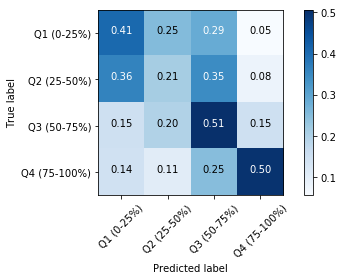

In [11]:
from sklearn.metrics import confusion_matrix

labels = ['9829 <= x <= 39457',
          '39458 <= x <= 54595', 
          '54596 <= x <= 73345', 
          '73346 <= x <= 244375']

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=labels)
# np.save('confusion_matrix.npy', cnf_matrix)
plot_confusion_matrix(cnf_matrix, classes=['Q1 (0-25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (75-100%)'], normalize=True, title='')